
.. index::
   triple: Equations; Stokes; Saddle-Point;

.. index:: Methods; Mixed FEM

.. index:: Spaces; Taylor-Hood

.. index:: Solvers; Petsc fieldsplit

# Stokes problem with fieldsplit preconditioner (PETSc)

Using the [Bercovier-Engelmann test case with analytical solution](https://numtourcfd.pages.math.cnrs.fr/doc/NumtourCFD/v1.0.1-alpha.2/applications/validation/bercovier-engelman.html) which was
originally published in <cite data-cite="BERCOVIER79"></cite>.
Equations for $f$ are taken from the benchmark document
<cite data-cite="TrioCFD"></cite>:

In [1]:
from matplotlib import pyplot
import numpy as np
import sys
try:
    import petsc4py
    petsc4py.init(sys.argv)
    from petsc4py import PETSc
except ImportError:
    print("Example requires `petsc4py` - skipping")
    sys.exit(0)

from dune.grid import structuredGrid
from ufl import div, grad, inner, dx, conditional, as_vector, eq, conditional
from ufl import SpatialCoordinate, TrialFunction, TestFunction
from ufl.constantvalue import Zero
from dune.ufl import DirichletBC, BoundaryId
from dune.fem.function import gridFunction
from dune.fem.space import lagrange, composite
from dune.fem import assemble

In [2]:
gridView = structuredGrid([0, 0], [1, 1], [7, 7])

velocity_order = 3
space_velocity = lagrange(gridView, dimRange=2, order=velocity_order, storage="petsc")
space_pressure = lagrange(gridView, order=velocity_order-1, storage="petsc")
taylor_hood_space = composite(space_velocity, space_pressure, components=["velocity", "pressure"])
x,y = SpatialCoordinate(taylor_hood_space)

def weak_form_stationary_stokes(u,v,p,q, f,mu, dirichlet_velocity=None):
    viscous_stress = mu*inner(grad(u), grad(v))*dx
    pressure_force = -p*div(v)*dx
    continuity = div(u)*q*dx
    lhs_terms = viscous_stress + pressure_force + continuity
    if f is None:
        return lhs_terms == 0
    else:
        return lhs_terms == inner(f, v)*dx

u_exact = gridFunction(256*y*(y-1)*(2*y-1)*x**2*(x-1)**2,
                      gridView,
                      name="analytical_solution_x",
                      order=5)
v_exact = gridFunction(256*x*(x-1)*(2*x-1)*y**2*(y-1)**2,
                      gridView,
                      name="analytical_solution_y",
                      order=5)
p_exact = gridFunction((x-0.5)*(y-0.5),
                      gridView,
                      name="analytical_solution_pressure",
                      order=5)
def f_1(x,y):
    return 256*(x**2*(x-1)**2*(12*y-6) + y*(y-1)*(2*y-1)*(12*x**2 -12*x + 2))
f_exact = gridFunction(as_vector([f_1(x,y) + (y-0.5), -f_1(y,x) +(x-0.5)]),
                      gridView,
                      name="analytical_solution_force_term",
                      order=5)

In [3]:
U,V      = TrialFunction(taylor_hood_space), TestFunction(taylor_hood_space)
u_h, v_h = as_vector([U[0], U[1]]), as_vector([V[0], V[1]])
p_h, q_h = U[2], V[2]

is_left  = eq(BoundaryId(taylor_hood_space),1)
is_right = eq(BoundaryId(taylor_hood_space),2)
is_bot   = eq(BoundaryId(taylor_hood_space),3)
is_top   = eq(BoundaryId(taylor_hood_space),4)
dirichlet_bcs_exact   = [DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_left),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_right),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_bot),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_top)]
eqns =  weak_form_stationary_stokes(u_h, v_h, p_h, q_h, f_exact, 1), *dirichlet_bcs_exact
A,b = assemble(eqns)
m = inner(grad(u_h), grad(v_h))*dx + p_h*q_h*dx
M = assemble([m,*dirichlet_bcs_exact])

In [4]:
A,M,b = A.as_petsc, M.as_petsc, b.as_petsc
ksp = PETSc.KSP().create()
ksp.setType(PETSc.KSP.Type.TFQMR)
pc = ksp.getPC()
pc.setType(PETSc.PC.Type.FIELDSPLIT)
idxVelo = PETSc.IS().createStride(size=space_velocity.size, first=0, step=1)
idxPres = PETSc.IS().createStride(size=space_pressure.size, first=space_velocity.size, step=1)
pc.setFieldSplitIS(('velo', idxVelo), ('pres', idxPres))
pc.setFieldSplitType(0)             # 0 means additive
subksps = pc.getFieldSplitSubKSP()
subksps[0].setType("preonly")
subksps[0].getPC().setType("hypre")
subksps[1].setType("preonly")
subksps[1].getPC().setType("hypre")
ksp.setOperators(A, M)
ksp.setFromOptions()

(x, _) = A.getVecs()
ksp.solve(b, x)
solution_vector_cg = taylor_hood_space.function(name="solution_vector_petsc", dofVector=x)

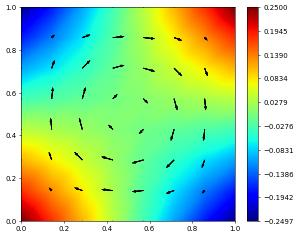

In [5]:
fig = pyplot.figure()
solution_vector_cg.plot(vectors=[0,1], gridLines=None, figure=fig)
solution_vector_cg[2].plot(figure=fig, gridLines=None)

The same solver using a standard pipe flow problem:

In [6]:
dbc  = DirichletBC(taylor_hood_space,[y*(1-y),0,None])
eqns = weak_form_stationary_stokes(u_h, v_h, p_h, q_h, None, 1), dbc
A,b  = assemble(eqns)
m    = inner(grad(u_h), grad(v_h))*dx + p_h*q_h*dx
M    = assemble([m,dbc])
ksp.setOperators(A.as_petsc, M.as_petsc)
ksp.solve(b.as_petsc, x)

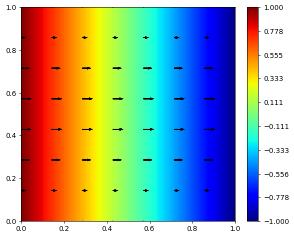

In [7]:
fig = pyplot.figure()
solution_vector_cg.plot(vectors=[0,1], gridLines=None, figure=fig)
solution_vector_cg[2].plot(figure=fig, gridLines=None)
pyplot.show()